## 1. Initialization
### 1.1 Import modules, set figure configurations, and loading tranined neural network

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import TiO2_NN_beta as TiO2NN


##  To organize figure style
def pltNormal():
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['figure.subplot.bottom'] = 0.15
    plt.rcParams['figure.subplot.left'] = 0.15
    plt.rcParams["font.size"]=12

def axNormal(ax):
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')

pltNormal()

calculator=TiO2NN.TiO2()

## 2 Check critical impact parameters, $b_{\rm{MD}}$ and $b_{\rm{NN}}$  
### 2.1 Calculation

In [8]:
strs=["0.6","1","2"]
MD=np.zeros(0)
NN=np.zeros(0)
v=np.zeros(0)
for s in strs:
    data=np.loadtxt("../MD_postProcessing/"+s+"nm.dat")
    for d in data:
        for b in np.arange(1,100,0.1):
            p=calculator.calculatePNN(d[0],d[1],b,d[2])[0]
            if(p==0.0):
                break
        MD=np.append(MD,d[3])
        NN=np.append(NN,b+1)
        v=np.append(v,d[2])
MD2=MD*MD
NN2=NN*NN
MDNN=MD*NN
N=np.size(MD)
X=N*np.sum(MD2)-(np.sum(MD))**2
Y=N*np.sum(NN2)-(np.sum(NN))**2
R2=(N*np.sum(MDNN)-np.sum(MD)*np.sum(NN))/(X**0.5*Y**0.5)
MSE=np.sum((MD-NN)**2)/N

### 2.2 Plot

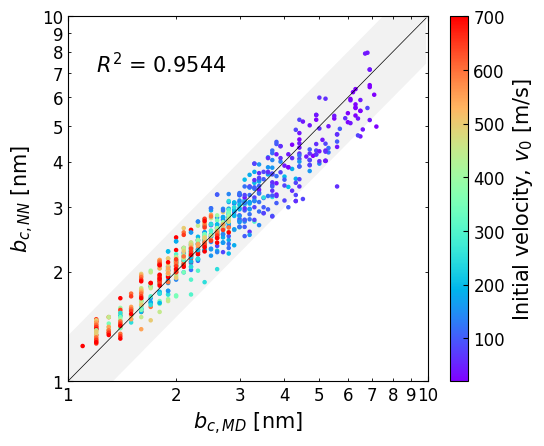

In [9]:
from matplotlib.ticker import FormatStrFormatter

x=np.arange(10,100)
fig, axs = plt.subplots(1,1,figsize=(6,5))
axNormal(axs)

axs.fill_between(x*0.1,x*0.1*0.75,x*0.1*1.333,color="gray",alpha=0.1,lw=0.01)
axs.fill_between(x,x*0.8,x*1.25,color="gray",alpha=0.15,lw=0.01)
axs.fill_between(x,x*0.5,x*2,color="gray",alpha=0.1,lw=0.01)
mainplt=axs.scatter(MD*0.1,NN*0.1,s=5,c=v,marker="o",cmap="rainbow")
axs.plot(x*0.1,x*0.1,linewidth=0.5,c="black")

axs.set_xlim([1,10])
axs.set_ylim([1,10])
axs.set_xscale("log")
axs.set_yscale("log")
axs.set_xlabel(r"$\it b_{c,MD}$ [nm]", fontsize=15)
axs.set_ylabel(r"$\it b_{c,NN}$ [nm]", fontsize=15)
axs.text(1.2,7,r"$\it R^{2}$ = "+'{:.4f}'.format(R2), fontsize=15)
cb=fig.colorbar(mainplt)
cb.set_label(r'Initial velocity, $v_0$ [m/s]', size=15)
axs.yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs.yaxis.set_minor_formatter(FormatStrFormatter('%d'))
axs.xaxis.set_major_formatter(FormatStrFormatter('%d'))
axs.xaxis.set_minor_formatter(FormatStrFormatter('%d'))
plt.savefig("MDNN.png", dpi=1000)
plt.show()

## 3 Check coagulation rate coefficient, $\beta _{\rm{MD}}$ and $\beta _{\rm{NN}}$
### 3.1 Calculation

In [24]:
T=1000
x=np.arange(1,10,0.01)
MD=np.zeros(0)
NN=np.zeros(0)
rcr=np.zeros(0)
f=open("beta-beta_"+str(int(T))+".dat","w")
for s in ["0.6nm","1nm","2nm"]:
    data=np.loadtxt("../MD_postProcessing/"+s+"_beta.dat")
    betaMD=data[np.where(data.T[3]==T)]
    for i in betaMD:
        ni=calculator.DtoN(i[0]*10)         # dp to N (1st cluster)
        nj=calculator.DtoN(i[1]*10)         # dp to N (2nd cluster)
        betaNN=calculator.calculateBetaNN(ni,nj,T)    # main calculation
        MD=np.append(MD,i[2])
        NN=np.append(NN,betaNN*0.95)
        rcr=np.append(rcr,(i[0]+i[1])*0.5)
        L=(i[0]+i[1])*0.5
        v0=(8*8.314*T/calculator.mij/np.pi)**0.5
        betaTH=(L*L*np.pi*v0)/1e18
        f.write(str(i[0]*10)+"\t"+str(i[1]*10)+"\t"+str(i[2])+"\t"+str(betaNN)+"\t"+str(betaTH)+"\n")
f.close()
MD2=MD*MD
NN2=NN*NN
MDNN=MD*NN
N=np.size(MD)
X=N*np.sum(MD2)-(np.sum(MD))**2
Y=N*np.sum(NN2)-(np.sum(NN))**2
R2=(N*np.sum(MDNN)-np.sum(MD)*np.sum(NN))/(X**0.5*Y**0.5)
MSE=np.sum((MD-NN)**2)/N

### 3.2 Plot

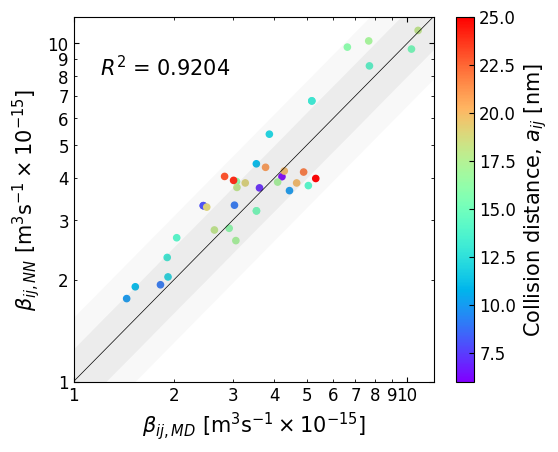

In [11]:
x=np.arange(1,12,0.01)
fig, axs = plt.subplots(1,1,figsize=(6,5))
axNormal(axs)

#axs.fill_between(x*0.1,x*0.1-1,x*0.1+1,color="gray",alpha=0.1,lw=0.01)
mainplt=axs.scatter(MD*1e15,NN*0.95e15,s=20,c=rcr*10,marker="o",cmap="rainbow")
axs.plot(x,x,linewidth=0.5,c="black")
axs.fill_between(x,x*0.8,x*1.25,color="gray",alpha=0.1,lw=0.01)
axs.fill_between(x,x*0.65,x*1.54,color="gray",alpha=0.05,lw=0.01)

axs.set_xlim([1,12])
axs.set_ylim([1,12])
axs.set_xlabel(r"$\beta _{ij,MD}$ $[\rm {m}^3 \rm{s}^{-1} \times 10^{-15}]$", fontsize=15)
axs.set_ylabel(r"$\beta _{ij,NN}$ $[\rm {m}^3 \rm{s}^{-1} \times 10^{-15}]$", fontsize=15)
axs.set_xscale("log")
axs.set_yscale("log")
#plt.ticklabel_format(style='sci', axis='y', useMathText=True)
#plt.ticklabel_format(style='sci', axis='x', useMathText=True)
axs.text(1.2,8,r"$\it R^{2}$ = "+'{:.4f}'.format(R2),fontsize=15)
cb=fig.colorbar(mainplt)
cb.set_label(r'Collision distance, $a_{ij}$ [nm]',size=15)
axs.yaxis.set_major_formatter(FormatStrFormatter('%d'))
axs.yaxis.set_minor_formatter(FormatStrFormatter('%d'))
axs.xaxis.set_major_formatter(FormatStrFormatter('%d'))
axs.xaxis.set_minor_formatter(FormatStrFormatter('%d'))
plt.savefig("MDNN_beta_"+str(int(T))+".png", dpi=1000)
plt.show()

## 4 Check coagulation rate coefficient & enhancement factor maps over all size particles
### 4.1 Calculation

In [35]:
T=300
dps=np.arange(6,30,1)
Ndp=np.size(dps)
betas=np.zeros((Ndp,Ndp))
etas=np.zeros((Ndp,Ndp))
for i in np.arange(Ndp):
    dpi=dps[i]
    for j in np.arange(i,Ndp):
        dpj=dps[j]
        ni=calculator.DtoN(dpi)         # dp to N (1st cluster)
        nj=calculator.DtoN(dpj)         # dp to N (2nd cluster)
        beta=calculator.calculateBetaNN(ni,nj,T)    # main calculation
        L=(dpi+dpj)*0.5
        v0=(8*8.314*T/calculator.mij/np.pi)**0.5
        eta=beta/(L*L*np.pi*v0)*1e20
        betas[i][j]=beta
        betas[j][i]=beta
        etas[i][j]=etas[j][i]=eta

np.savetxt("./NNmapping/betaNN"+str(int(T))+".DAT",betas)
np.savetxt("./NNmapping/etaNN"+str(int(T))+".DAT",etas)


### 4.2 Plot

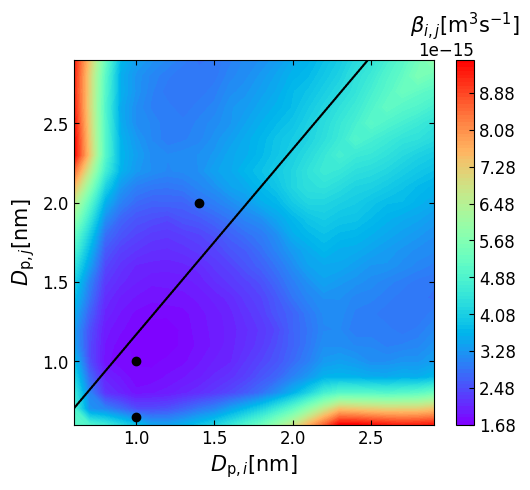

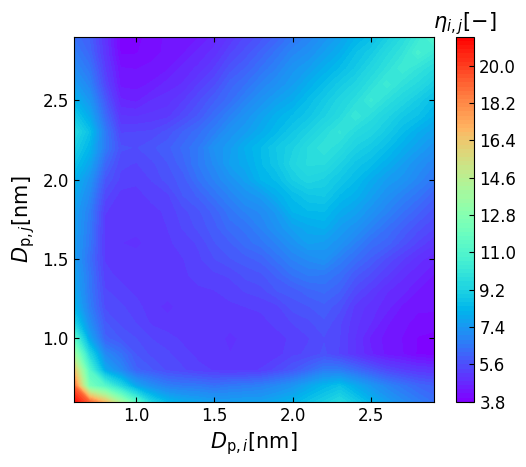

In [63]:
from mpl_toolkits import mplot3d
from matplotlib import ticker
niceMathTextForm = ticker.ScalarFormatter(useMathText=True)

betas=np.loadtxt("./NNmapping/betaNN"+str(int(T))+".DAT")
etas=np.loadtxt("./NNmapping/etaNN"+str(int(T))+".DAT")

fig, axs = plt.subplots(1,1,figsize=(6,5))
axNormal(axs)
X, Y = np.meshgrid(dps*0.1, dps*0.1)
cont=axs.contourf(X, Y, betas, 100, cmap='rainbow')
cbar=fig.colorbar(cont)
cbar.ax.set_title(r"$\beta_{i,j} {\rm [m^3 s^{-1}]}$",fontsize=15) 
axs.set_xlabel(r"$D_{{\rm p},i} {\rm [nm]}$",size="15")
axs.set_ylabel(r"$D_{{\rm p},j} {\rm [nm]}$",size="15")

Mmono=(16+16+48)*1e-3
dpsTH=np.linspace(0.6,2.9,1000)
nsTH=(dpsTH/10.0)**3*48.0
msTH=nsTH/3.0*Mmono
minsTH=np.zeros(1000)
for i in np.arange(1000):
    L=(dpsTH[i]+dpsTH)*0.5
    mij=1/(1/msTH[i]+1/msTH)
    v0=(8*8.314*T/mij/np.pi)**0.5
    betaTH=(L*L*np.pi*v0)*1e20
    index=np.where(np.min(betaTH)==betaTH)
    minsTH[i]=dpsTH[index]
plt.plot(minsTH,dpsTH,c="black")
'''
Mmono=(16+16+48)*1e-3
ns=(dps/10.0)**3*48.0
ms=ns/3.0*Mmono
mins=np.zeros(np.size(dps))
print(dps)
print(betas[0])
for i in np.arange(np.size(dps)):
    index=np.where(np.min(betas[i])==betas[i])
    mins[i]=dps[index]
plt.scatter(mins*0.1,dps*0.1)
'''

minsMD=[1.0,1.0,1.4]
dpsMD=[0.65,1.0,2.0]
plt.scatter(minsMD,dpsMD,c="black")

plt.savefig("./NNmapping/betaMap"+str(int(T))+".png", dpi=1000)
plt.show()

fig, axs = plt.subplots(1,1,figsize=(6,5))
axNormal(axs)
X, Y = np.meshgrid(dps*0.1, dps*0.1)
cont=axs.contourf(X, Y, etas, 100, cmap='rainbow')
cbar=fig.colorbar(cont)
cbar.ax.set_title(r"$\eta_{i,j} {\rm [-]}$",fontsize=15) 
axs.set_xlabel(r"$D_{{\rm p},i} {\rm [nm]}$",size="15")
axs.set_ylabel(r"$D_{{\rm p},j} {\rm [nm]}$",size="15")
plt.savefig("./NNmapping/enhanceMap"+str(int(T))+".png", dpi=1000)
plt.show()

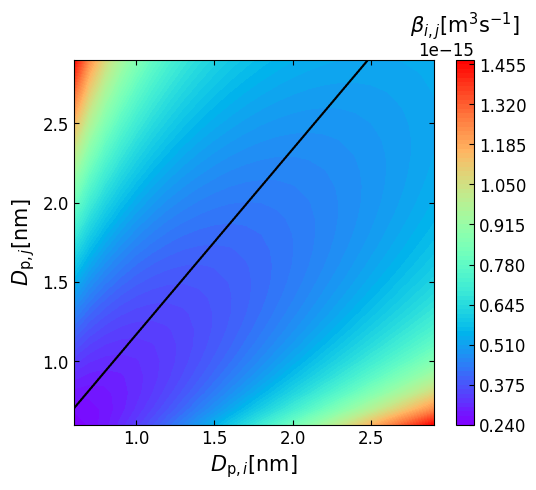

In [57]:
from mpl_toolkits import mplot3d
from matplotlib import ticker
niceMathTextForm = ticker.ScalarFormatter(useMathText=True)

betas=np.loadtxt("./NNmapping/betaNN"+str(int(T))+".DAT")
etas=np.loadtxt("./NNmapping/etaNN"+str(int(T))+".DAT")

fig, axs = plt.subplots(1,1,figsize=(6,5))
axNormal(axs)
X, Y = np.meshgrid(dps*0.1, dps*0.1)
cont=axs.contourf(X, Y, betas/etas, 100, cmap='rainbow')
cbar=fig.colorbar(cont)
cbar.ax.set_title(r"$\beta_{i,j} {\rm [m^3 s^{-1}]}$",fontsize=15) 
axs.set_xlabel(r"$D_{{\rm p},i} {\rm [nm]}$",size="15")
axs.set_ylabel(r"$D_{{\rm p},j} {\rm [nm]}$",size="15")

Mmono=(16+16+48)*1e-3
dpsTH=np.linspace(0.6,2.9,1000)
nsTH=(dpsTH/10.0)**3*48.0
msTH=nsTH/3.0*Mmono
minsTH=np.zeros(1000)
for i in np.arange(1000):
    L=(dpsTH[i]+dpsTH)*0.5
    mij=1/(1/msTH[i]+1/msTH)
    v0=(8*8.314*T/mij/np.pi)**0.5
    betaTH=(L*L*np.pi*v0)*1e20
    index=np.where(np.min(betaTH)==betaTH)
    minsTH[i]=dpsTH[index]
plt.plot(minsTH,dpsTH,c="black")

plt.savefig("./NNmapping/betaMapTH"+str(int(T))+".png", dpi=1000)
plt.show()

[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
[5.13976828e-15 4.90222852e-15 4.62960413e-15 4.23288728e-15
 3.84219791e-15 3.41274394e-15 3.39241718e-15 3.58173706e-15
 3.84138753e-15 4.11822199e-15 4.48218251e-15 4.93459829e-15
 5.35501392e-15 5.99048224e-15 6.67232542e-15 7.58615558e-15
 8.52022803e-15 9.57769944e-15 9.58307226e-15 9.44072719e-15
 9.30895786e-15 9.21497789e-15 9.25988670e-15 9.31674701e-15]


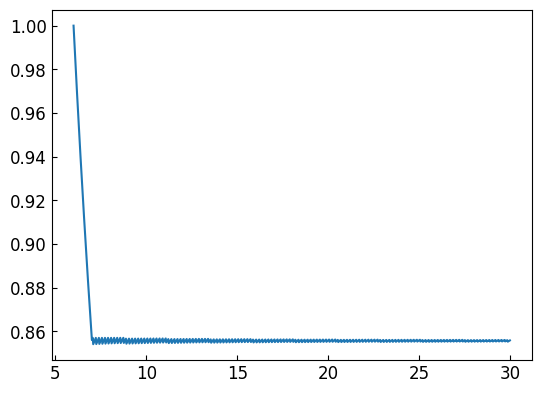

In [50]:
Mmono=(16+16+48)*1e-3
ns=(dps/10.0)**3*48.0
ms=ns/3.0*Mmono
mins=np.zeros(np.size(dps))
print(dps)
print(betas[0])
for i in np.arange(np.size(dps)):
    index=np.where(np.min(betas[i])==betas[i])
    mins[i]=dps[index]
#plt.scatter(dps,mins)

dpsTH=np.linspace(0.6,3.0,1000)
nsTH=(dpsTH/10.0)**3*48.0
msTH=nsTH/3.0*Mmono
minsTH=np.zeros(1000)
for i in np.arange(1000):
    L=(dpsTH[i]+dpsTH)*0.5
    mij=1/(1/msTH[i]+1/msTH)
    v0=(8*8.314*T/mij/np.pi)**0.5
    betaTH=(L*L*np.pi*v0)*1e20
    index=np.where(np.min(betaTH)==betaTH)
    minsTH[i]=dpsTH[index]
plt.plot(dpsTH*10,minsTH/dpsTH)